<a href="https://colab.research.google.com/github/heesukjang/W266_NLP_With_DeepLearning/blob/main/Final_Project/v9_Regression_withBERT_4_4_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Update the version of tensorflow to 2.11.0**

In [248]:
# !pip uninstall tensorflow              # uninstall the current version of tf that Colab automatically installs
# !pip install tensorflow==2.11.0        # install 2.11.0 version, which the model worked at that point with a GPU
# # Next step: go to "Runtime" and "Restart runtime"
# # then confirm if the version is properly updated to 2.11.0 by running the followin print statement - "import tensorflow as tf | print(tf.__version__)"

# Check the version of tensorflow

In [249]:
import tensorflow as tf
print(tf.__version__)

2.11.0


# Install New Libraries

In [250]:
!pip install nltk
!pip install wordcloud
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Importing Libraries**

In [251]:
import random

#NLP related libraries
import transformers
print(f'transformers version: {transformers.__version__}')
from transformers import logging as hf_logging
from transformers import BertTokenizer, TFBertModel
hf_logging.set_verbosity_error()
import nltk
from nltk.tokenize import sent_tokenize
import spacy      
from spacy import displacy
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from wordcloud import ImageColorGenerator
from sklearn.model_selection import train_test_split
nltk.download('punkt')

# Other required libraries
import os
import pandas as pd
pd.set_option('display.width', 180)    # increase pandas display output in Colab
import numpy as np
import re
import copy
import sys
import datetime
import time
from keras.utils.layer_utils import count_params
import locale
locale.getpreferredencoding = lambda: "UTF-8"
import warnings
warnings.filterwarnings("ignore")

# Data visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.layer_utils import count_params
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import mae
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.losses import binary_crossentropy
from keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from keras.models import load_model

from google.colab import drive
drive.mount('/content/gdrive')

transformers version: 4.27.4


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **General Functions**

## **Set Config Parameters**

In [252]:
def set_config_param(seed = 99):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.backend.clear_session()
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_columns', None)
    
    
set_config_param(20230214)

## **Count Plot**

In [253]:
# def plot_count(df, labels):
#   sns.set_style('whitegrid')
#   plt.figure(figsize=(18,10))
#   for idx, label in enumerate(labels):
#       plt.subplot(2, 3, idx+1)
#       sns.countplot(x = label, data = df)

## **Adding Feature Columns**

In [254]:
def add_feature(df):

    # Cleaning up full_text : Removing tabl and carriage return characters
    df['full_text'] = df["full_text"].replace(re.compile(r'[\n\r\t]'), ' ', regex=True)

    # Adding word count, sentence count, total score and full text length
    df['word_count'] = df['full_text'].apply(lambda x: len(x.split()))
    df['sentence_count'] = df['full_text'].apply(lambda x: len(sent_tokenize(x)))
    df['total_score'] = df['cohesion'] + df_train['syntax'] + df['vocabulary'] + df['phraseology'] + df['grammar'] + df['conventions']
    df['full_text_len'] = df['full_text'].apply(lambda x: len(x))

    # Adding mean, median score per label and indicator column 
    # whether the label value is below or above mean or median value
    for label in label_cols:
        df[label + '_avg_score'] = np.mean(df[label])
        df[label + '_above_or_below_avg_flag'] = np.where(df[label] > np.mean(df[label]), 1, 0)  
        df[label + '_median_score'] = np.median(df[label])
        df[label + '_above_or_below_median_flag'] = np.where(df[label] > np.median(df[label]), 1, 0)  
        df[label + '_rounded_val'] = np.round(df[label])  
    
    return df

## **Getting Unique Values for Each Label**

In [255]:
# def get_unique_values_for_labels(df, col_list):
#     print('Unique Values in Each Metric:\n==================================================')
#     for col in col_list:
#         print(f'{col}: {df[col].unique()}')

## **Getting Value Counts for Each Label**

In [256]:
# def get_value_counts_for_labels(df, col_list):
#     print('Counts for Each Metric:\n==================================================')
#     for col in col_list:
#         print(f"Column: {col}")
#         print(f'{df[col].value_counts().sort_values()}')
#         print("*****")

## **Getting Histogram for a Column**

In [257]:
# def get_histogram_for_col(df, col_list, col_name):
#     sns.set_style('whitegrid')
#     plt.figure(figsize=(18,10))
#     for idx, label in enumerate(col_list):
#         plt.subplot(2, 3, idx+1)
#         sns.histplot(x=col_name, hue = label, data = df)
#         plt.xlabel('Word Count', fontsize=10)

## **Getting Count Plot for Indicator Columns**

In [258]:
# def get_count_plot_for_ind_col(df, search_string, col_list):
#     fig, ax = plt.subplots(1, len(col_list), figsize=(50,10))
#     for idx, label in enumerate(col_list):
#         sns.countplot(x = df[label + search_string], ax = ax[idx])
#         ax[idx].set_title(label)

## **Getting Bar Plot for Each Label**

In [259]:
# def get_barplot_for_each_label(df, col_list, search_string):
#     avg_score_cols = [col + search_string for col in col_list]
#     plt.figure(figsize=(8,5))
#     ax = sns.barplot(x=col_list, y=np.array(df[avg_score_cols].drop_duplicates())[0], palette='rocket')
#     plt.xlabel('Scoring Metric', fontsize=12)
#     if search_string == '_avg_score':
#         plt.ylabel('Average Score', fontsize=12)
#         plt.title('Average Score in Each Metric', fontsize=16)
#     elif search_string == '_median_score':
#         plt.ylabel('Median Score', fontsize=12)
#         plt.title('Median Score in Each Metric', fontsize=16)

## **Label Processing**

In [260]:
def get_cat_label_cols(col_list):
    return ['cat_' + col for col in col_list]

In [261]:
def apply_label_map(df, label_map, col_list):
  for col in col_list:
      df[col + '_map'] = df[col].map(label_map)
  return df

In [262]:
def get_label_values(df, col_list):
    return [np.array(df[col]) for col in col_list]

In [263]:
def get_label_dict(df, col_list_1, col_list_2):
    return dict(zip(col_list_2, get_label_values(df, col_list_1)))

## **Plot Loss and Accuracy**

In [264]:
# def plot_loss_accuracy(history, col_list):
#     fig, ax = plt.subplots(2, 6, figsize=(16, 6), sharex='col', sharey='row')
#     fig.tight_layout(pad=5.0)
#     for idx, col in enumerate(col_list):

#         ax[0, idx].plot(history[col + '_loss'], lw=2, color='darkgoldenrod')
#         ax[0, idx].plot(history['val_' + col + '_loss'], lw=2, color='indianred')
#         #ax[0, idx].legend(loc='center left')
#         ax[0, idx].legend(['Train', 'Validation'], fontsize=5)
#         ax[0, idx].set_xlabel('Epochs', size=10)
#         ax[0, idx].set_title('Loss: ' + col)

#         ax[1, idx].plot(history[col + '_accuracy'], lw=2, color='darkgoldenrod')
#         ax[1, idx].plot(history['val_' + col + '_accuracy'], lw=2, color='indianred')
#         #ax[0, idx].legend(loc='center left')
#         ax[1, idx].legend(['Train', 'Validation'], fontsize=5)
#         ax[1, idx].set_xlabel('Epochs', size=10)
#         ax[1, idx].set_title('Accuracy: ' + col)

##**[MCRMSE (Mean Column-wise Root Mean Squared Error)](https://www.kaggle.com/competitions/feedback-prize-english-language-learning/overview/evaluation)**<br>
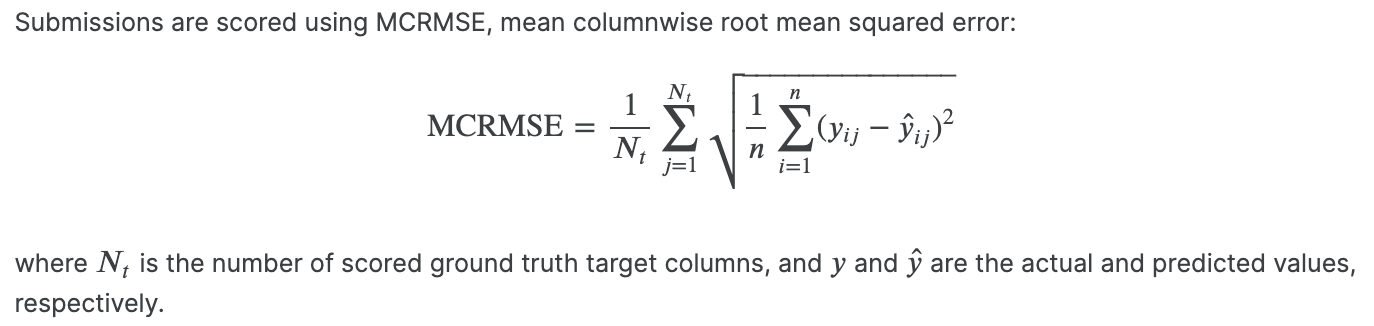

In [ ]:
tfa.metrics.RSquare()

In [265]:
def MCRMSE(y_true, y_pred):
  colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
  return tf.reduce_mean(tf.sqrt(colwise_mse), axis=-1, keepdims=True)

In [266]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# https://medium.com/ilb-labs-publications/fine-tuning-bert-for-a-regression-task-is-a-description-enough-to-predict-a-propertys-list-price-cf97cd7cb98a
def mae_mdae(y_true, y_pred):  
  mae = mean_absolute_error(y_true, y_pred)
  mdae = median_absolute_error(y_true, y_pred)
  return mae, mdae

In [267]:
# def r_squared(y_true, y_pred):
#   # r_squared = r2_score(y_true, y_pred)
#   total_error = tf.reduce_sum(tf.square(tf.sub(y, tf.reduce_mean(y))))
#   unexplained_error = tf.reduce_sum(tf.square(tf.sub(y, prediction)))
#   r_squared = tf.sub(1, tf.div(unexplained_error, total_error))
#   return r_squared  

# # regression_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
# #                         loss=MCRMSE,
# #                         metrics=MCRMSE) 

# **Load Input Files**

In [268]:
train_path = '/content/gdrive/MyDrive/Kaggle/train.csv'
test_path = '/content/gdrive/MyDrive/Kaggle/test.csv'

input_train_df = pd.read_csv(train_path)
input_test_df = pd.read_csv(test_path)

# input_train_df = pd.read_csv('train.csv')
# input_test_df = pd.read_csv('test.csv')

float_labels, int_map_labels = np.arange(1, 5.5, 0.5), np.arange(9)
label_map = dict(zip(float_labels, int_map_labels))

float_scaled_labels, int_scaled_labels = np.arange(1, 6, 1), np.arange(6)
label_scaled_map = dict(zip(float_scaled_labels, int_scaled_labels))

orig_train_df = copy.deepcopy(input_train_df)
orig_train_df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


"Map" columns are basically scaled columns of the original metric values. There are total 9 levels in map columns. Original mretric columns range from 1 to 5. Through map columns, they range from 0 to 8.

"Scaled" columns map numbers .5, 1.5, 2.5, 3.5 and 4.5 to nearset integers. Thus it will have range from 1 to 5.

In [269]:
label_map

{1.0: 0, 1.5: 1, 2.0: 2, 2.5: 3, 3.0: 4, 3.5: 5, 4.0: 6, 4.5: 7, 5.0: 8}

In [270]:
label_scaled_map

{1: 0, 2: 1, 3: 2, 4: 3, 5: 4}

# **Split Data** into **3 Dataframes**
- df_train
- df_val
- df_test

Original test data is very limited, there are only 3 records and it does not have labels to test. So we decided to repurpose the given train data to split into train, test and validation sets.

In [271]:
shuffle = np.random.permutation(np.arange(orig_train_df.shape[0]))
orig_train_df = orig_train_df.iloc[shuffle]
split=(0.8,0.1,0.1)
splits = np.multiply(len(orig_train_df), split).astype(int)
df_train, df_val, df_test = np.split(orig_train_df, [splits[0], splits[0] + splits[1]])
df_train.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
134,0A8B8F282E45,"Winston Churchill once said ""success consists ...",3.0,2.0,2.5,2.5,2.5,2.5
1470,71BA665B1B31,I think that imagination is not more important...,3.0,4.0,3.0,3.5,3.5,3.0
1216,5EA71157D48F,I supported that people make their own decisio...,2.5,2.5,2.5,2.5,3.0,3.5
3705,F7B5DF87EA1D,"If we didn't take a action, What should we do?...",2.5,2.5,3.0,3.0,3.5,3.5
2121,9EBCC1131B13,"As we have two different people, we have two t...",4.5,3.0,4.0,3.5,3.0,3.5


In [272]:
label_cols = df_train.columns[2:]
print(label_cols)
label_rounded_cols = [col + '_rounded_val' for col in label_cols]
label_map_cols = [col + '_map' for col in label_cols]
cat_label_cols = get_cat_label_cols(label_cols)

df_train = apply_label_map(df_train, label_map, label_cols)
df_test = apply_label_map(df_test, label_map, label_cols)
df_val = apply_label_map(df_val, label_map, label_cols)

Index(['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions'], dtype='object')


In [273]:
label_cols, label_rounded_cols, label_map_cols, cat_label_cols

(Index(['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions'], dtype='object'),
 ['cohesion_rounded_val',
  'syntax_rounded_val',
  'vocabulary_rounded_val',
  'phraseology_rounded_val',
  'grammar_rounded_val',
  'conventions_rounded_val'],
 ['cohesion_map',
  'syntax_map',
  'vocabulary_map',
  'phraseology_map',
  'grammar_map',
  'conventions_map'],
 ['cat_cohesion',
  'cat_syntax',
  'cat_vocabulary',
  'cat_phraseology',
  'cat_grammar',
  'cat_conventions'])

# **Addiung Other Feature Columns**

In [274]:
df_train = add_feature(df_train)
df_test = add_feature(df_test)
df_val = add_feature(df_val)

# **EDA**

In [275]:
df_train.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,cohesion_map,syntax_map,vocabulary_map,phraseology_map,grammar_map,conventions_map,word_count,sentence_count,total_score,full_text_len,cohesion_avg_score,cohesion_above_or_below_avg_flag,cohesion_median_score,cohesion_above_or_below_median_flag,cohesion_rounded_val,syntax_avg_score,syntax_above_or_below_avg_flag,syntax_median_score,syntax_above_or_below_median_flag,syntax_rounded_val,vocabulary_avg_score,vocabulary_above_or_below_avg_flag,vocabulary_median_score,vocabulary_above_or_below_median_flag,vocabulary_rounded_val,phraseology_avg_score,phraseology_above_or_below_avg_flag,phraseology_median_score,phraseology_above_or_below_median_flag,phraseology_rounded_val,grammar_avg_score,grammar_above_or_below_avg_flag,grammar_median_score,grammar_above_or_below_median_flag,grammar_rounded_val,conventions_avg_score,conventions_above_or_below_avg_flag,conventions_median_score,conventions_above_or_below_median_flag,conventions_rounded_val
134,0A8B8F282E45,"Winston Churchill once said ""success consists ...",3.0,2.0,2.5,2.5,2.5,2.5,4,2,3,3,3,3,446,15,15.0,2373,3.128676,0,3.0,0,3.0,3.03133,0,3.0,0,2.0,3.235134,0,3.0,0,2.0,3.123242,0,3.0,0,2.0,3.029252,0,3.0,0,2.0,3.081841,0,3.0,0,2.0
1470,71BA665B1B31,I think that imagination is not more important...,3.0,4.0,3.0,3.5,3.5,3.0,4,6,4,5,5,4,226,14,20.0,1216,3.128676,0,3.0,0,3.0,3.03133,1,3.0,1,4.0,3.235134,0,3.0,0,3.0,3.123242,1,3.0,1,4.0,3.029252,1,3.0,1,4.0,3.081841,0,3.0,0,3.0
1216,5EA71157D48F,I supported that people make their own decisio...,2.5,2.5,2.5,2.5,3.0,3.5,3,3,3,3,4,5,164,7,16.5,841,3.128676,0,3.0,0,2.0,3.03133,0,3.0,0,2.0,3.235134,0,3.0,0,2.0,3.123242,0,3.0,0,2.0,3.029252,0,3.0,0,3.0,3.081841,1,3.0,1,4.0
3705,F7B5DF87EA1D,"If we didn't take a action, What should we do?...",2.5,2.5,3.0,3.0,3.5,3.5,3,3,4,4,5,5,347,25,18.0,1876,3.128676,0,3.0,0,2.0,3.03133,0,3.0,0,2.0,3.235134,0,3.0,0,3.0,3.123242,0,3.0,0,3.0,3.029252,1,3.0,1,4.0,3.081841,1,3.0,1,4.0
2121,9EBCC1131B13,"As we have two different people, we have two t...",4.5,3.0,4.0,3.5,3.0,3.5,7,4,6,5,4,5,573,19,21.5,3176,3.128676,1,3.0,1,4.0,3.03133,0,3.0,0,3.0,3.235134,1,3.0,1,4.0,3.123242,1,3.0,1,4.0,3.029252,0,3.0,0,3.0,3.081841,1,3.0,1,4.0


In [276]:
for col in label_cols:
    print(df_train[col + '_rounded_val'].unique())

[3. 2. 4. 1. 5.]
[2. 4. 3. 1. 5.]
[2. 3. 4. 1. 5.]
[2. 4. 3. 5. 1.]
[2. 4. 3. 1. 5.]
[2. 3. 4. 1. 5.]


In [277]:
df_train.iloc[0]

text_id                                                                        0A8B8F282E45
full_text                                 Winston Churchill once said "success consists ...
cohesion                                                                                3.0
syntax                                                                                  2.0
vocabulary                                                                              2.5
phraseology                                                                             2.5
grammar                                                                                 2.5
conventions                                                                             2.5
cohesion_map                                                                              4
syntax_map                                                                                2
vocabulary_map                                                                  

In [278]:
df_test.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,cohesion_map,syntax_map,vocabulary_map,phraseology_map,grammar_map,conventions_map,word_count,sentence_count,total_score,full_text_len,cohesion_avg_score,cohesion_above_or_below_avg_flag,cohesion_median_score,cohesion_above_or_below_median_flag,cohesion_rounded_val,syntax_avg_score,syntax_above_or_below_avg_flag,syntax_median_score,syntax_above_or_below_median_flag,syntax_rounded_val,vocabulary_avg_score,vocabulary_above_or_below_avg_flag,vocabulary_median_score,vocabulary_above_or_below_median_flag,vocabulary_rounded_val,phraseology_avg_score,phraseology_above_or_below_avg_flag,phraseology_median_score,phraseology_above_or_below_median_flag,phraseology_rounded_val,grammar_avg_score,grammar_above_or_below_avg_flag,grammar_median_score,grammar_above_or_below_median_flag,grammar_rounded_val,conventions_avg_score,conventions_above_or_below_avg_flag,conventions_median_score,conventions_above_or_below_median_flag,conventions_rounded_val
3317,E587CBD5D1E4,How we know the first impression is important ...,3.5,2.5,3.5,3.5,2.5,3.0,5,3,5,5,3,4,265,8,NaN,1350,3.105867,1,3.0,1,4.0,3.010204,0,3.0,0,2.0,3.242347,1,3.0,1,4.0,3.067602,1,3.0,1,4.0,3.042092,0,3.0,0,2.0,3.068878,0,3.0,0,3.0
3172,DF149975C610,I agree with emerson's statement. I will grow ...,3.0,3.0,3.0,3.5,2.5,3.0,4,4,4,5,3,4,502,39,NaN,2534,3.105867,0,3.0,0,3.0,3.010204,0,3.0,0,3.0,3.242347,0,3.0,0,3.0,3.067602,1,3.0,1,4.0,3.042092,0,3.0,0,2.0,3.068878,0,3.0,0,3.0
2999,D7301CAAFAB0,When are parents gave us advice we are able to...,2.5,2.0,2.5,2.0,2.0,3.0,3,2,3,2,2,4,496,27,NaN,2449,3.105867,0,3.0,0,2.0,3.010204,0,3.0,0,2.0,3.242347,0,3.0,0,2.0,3.067602,0,3.0,0,2.0,3.042092,0,3.0,0,2.0,3.068878,0,3.0,0,3.0
2824,CDDCA13DB734,The determination make us to do something and ...,3.5,3.0,3.0,2.5,2.5,3.5,5,4,4,3,3,5,309,14,NaN,1567,3.105867,1,3.0,1,4.0,3.010204,0,3.0,0,3.0,3.242347,0,3.0,0,3.0,3.067602,0,3.0,0,2.0,3.042092,0,3.0,0,2.0,3.068878,1,3.0,1,4.0
310,16B9EB49892E,"The should be people make their own decision, ...",2.5,2.5,2.5,2.0,2.5,2.0,3,3,3,2,3,2,169,9,NaN,926,3.105867,0,3.0,0,2.0,3.010204,0,3.0,0,2.0,3.242347,0,3.0,0,2.0,3.067602,0,3.0,0,2.0,3.042092,0,3.0,0,2.0,3.068878,0,3.0,0,2.0


In [279]:
df_val.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,cohesion_map,syntax_map,vocabulary_map,phraseology_map,grammar_map,conventions_map,word_count,sentence_count,total_score,full_text_len,cohesion_avg_score,cohesion_above_or_below_avg_flag,cohesion_median_score,cohesion_above_or_below_median_flag,cohesion_rounded_val,syntax_avg_score,syntax_above_or_below_avg_flag,syntax_median_score,syntax_above_or_below_median_flag,syntax_rounded_val,vocabulary_avg_score,vocabulary_above_or_below_avg_flag,vocabulary_median_score,vocabulary_above_or_below_median_flag,vocabulary_rounded_val,phraseology_avg_score,phraseology_above_or_below_avg_flag,phraseology_median_score,phraseology_above_or_below_median_flag,phraseology_rounded_val,grammar_avg_score,grammar_above_or_below_avg_flag,grammar_median_score,grammar_above_or_below_median_flag,grammar_rounded_val,conventions_avg_score,conventions_above_or_below_avg_flag,conventions_median_score,conventions_above_or_below_median_flag,conventions_rounded_val
299,16005A45A20A,There's 90% of people in the world that wants ...,4.0,3.0,3.0,3.0,3.5,3.5,6,4,4,4,5,5,1072,47,NaN,5449,3.13555,1,3.0,1,4.0,3.021739,0,3.0,0,3.0,3.234015,0,3.0,0,3.0,3.11509,0,3.0,0,3.0,3.05243,1,3.0,1,4.0,3.086957,1,3.0,1,4.0
1371,698A3F2B43B9,Have you ever thought about staring your futur...,4.0,3.0,4.0,3.5,3.5,3.0,6,4,6,5,5,4,650,29,NaN,3372,3.13555,1,3.0,1,4.0,3.021739,0,3.0,0,3.0,3.234015,1,3.0,1,4.0,3.11509,1,3.0,1,4.0,3.05243,1,3.0,1,4.0,3.086957,0,3.0,0,3.0
3087,DB34A89420F2,I understand why you want to add an hour and t...,2.5,3.0,3.0,2.5,3.5,3.0,3,4,4,3,5,4,486,13,NaN,2508,3.13555,0,3.0,0,2.0,3.021739,0,3.0,0,3.0,3.234015,0,3.0,0,3.0,3.11509,0,3.0,0,2.0,3.05243,1,3.0,1,4.0,3.086957,0,3.0,0,3.0
1047,4FE6EABBFC00,One topic that is frequently debated is if peo...,5.0,4.5,4.0,4.5,4.0,4.5,8,7,6,7,6,7,194,10,NaN,1128,3.13555,1,3.0,1,5.0,3.021739,1,3.0,1,4.0,3.234015,1,3.0,1,4.0,3.11509,1,3.0,1,4.0,3.05243,1,3.0,1,4.0,3.086957,1,3.0,1,4.0
1453,6FEF6D46714D,Has it ever crossed your mind that people toda...,2.5,3.5,3.5,3.5,3.5,2.5,3,5,5,5,5,3,597,27,NaN,3239,3.13555,0,3.0,0,2.0,3.021739,1,3.0,1,4.0,3.234015,1,3.0,1,4.0,3.11509,1,3.0,1,4.0,3.05243,1,3.0,1,4.0,3.086957,0,3.0,0,2.0


In [280]:
df_train.shape, df_test.shape, df_val.shape

((3128, 48), (392, 48), (391, 48))

In [281]:
df_train.describe()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions,cohesion_map,syntax_map,vocabulary_map,phraseology_map,grammar_map,conventions_map,word_count,sentence_count,total_score,full_text_len,cohesion_avg_score,cohesion_above_or_below_avg_flag,cohesion_median_score,cohesion_above_or_below_median_flag,cohesion_rounded_val,syntax_avg_score,syntax_above_or_below_avg_flag,syntax_median_score,syntax_above_or_below_median_flag,syntax_rounded_val,vocabulary_avg_score,vocabulary_above_or_below_avg_flag,vocabulary_median_score,vocabulary_above_or_below_median_flag,vocabulary_rounded_val,phraseology_avg_score,phraseology_above_or_below_avg_flag,phraseology_median_score,phraseology_above_or_below_median_flag,phraseology_rounded_val,grammar_avg_score,grammar_above_or_below_avg_flag,grammar_median_score,grammar_above_or_below_median_flag,grammar_rounded_val,conventions_avg_score,conventions_above_or_below_avg_flag,conventions_median_score,conventions_above_or_below_median_flag,conventions_rounded_val
count,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.0,3128.000000,3128.000000,3128.00000,3128.000000,3128.0,3128.000000,3128.000000,3.128000e+03,3128.000000,3128.0,3128.000000,3128.000000,3.128000e+03,3128.000000,3128.0,3128.000000,3128.000000,3128.000000,3128.000000,3128.0,3128.000000,3128.000000,3.128000e+03,3128.000000,3128.0,3128.000000,3128.000000
mean,3.128676,3.031330,3.235134,3.123242,3.029252,3.081841,4.257353,4.062660,4.470269,4.246483,4.058504,4.163683,431.981458,18.186061,18.629476,2341.242327,3.128676,0.429348,3.0,0.429348,3.143542,3.03133,0.351662,3.0,0.351662,3.023338,3.235134e+00,0.445332,3.0,0.445332,3.283887,3.123242e+00,0.417519,3.0,0.417519,3.130754,3.029252,0.378836,3.0,0.378836,3.018862,3.081841e+00,0.397059,3.0,0.397059,3.086637
std,0.660566,0.642023,0.582582,0.656872,0.697791,0.670081,1.321132,1.284046,1.165164,1.313744,1.395581,1.340161,191.928298,10.180678,3.355094,1029.872033,0.000000,0.495062,0.0,0.495062,0.853247,0.00000,0.477566,0.0,0.477566,0.838645,4.441602e-16,0.497082,0.0,0.497082,0.755728,4.441602e-16,0.493229,0.0,0.493229,0.847789,0.000000,0.485175,0.0,0.485175,0.876785,4.441602e-16,0.489367,0.0,0.489367,0.855674
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,51.000000,1.000000,6.000000,269.000000,3.128676,0.000000,3.0,0.000000,1.000000,3.03133,0.000000,3.0,0.000000,1.000000,3.235134e+00,0.000000,3.0,0.000000,1.000000,3.123242e+00,0.000000,3.0,0.000000,1.000000,3.029252,0.000000,3.0,0.000000,1.000000,3.081841e+00,0.000000,3.0,0.000000,1.000000
25%,2.500000,2.500000,3.000000,2.500000,2.500000,2.500000,3.000000,3.000000,4.000000,3.000000,3.000000,3.000000,294.750000,10.000000,16.000000,1601.000000,3.128676,0.000000,3.0,0.000000,2.000000,3.03133,0.000000,3.0,0.000000,2.000000,3.235134e+00,0.000000,3.0,0.000000,3.000000,3.123242e+00,0.000000,3.0,0.000000,2.000000,3.029252,0.000000,3.0,0.000000,2.000000,3.081841e+00,0.000000,3.0,0.000000,2.000000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,401.000000,17.000000,18.500000,2174.000000,3.128676,0.000000,3.0,0.000000,3.000000,3.03133,0.000000,3.0,0.000000,3.000000,3.235134e+00,0.000000,3.0,0.000000,3.000000,3.123242e+00,0.000000,3.0,0.000000,3.000000,3.029252,0.000000,3.0,0.000000,3.000000,3.081841e+00,0.000000,3.0,0.000000,3.000000
75%,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,530.000000,24.000000,21.000000,2869.250000,3.128676,1.000000,3.0,1.000000,4.000000,3.03133,1.000000,3.0,1.000000,4.000000,3.235134e+00,1.000000,3.0,1.000000,4.000000,3.123242e+00,1.000000,3.0,1.000000,4.000000,3.029252,1.000000,3.0,1.000000,4.000000,3.081841e+00,1.000000,3.0,1.000000,4.000000
max,5.000000,5.000000,5.000000,5

In [282]:
# df_train.columns

## **Unique Values for Each Label**

In [283]:
# get_unique_values_for_labels(df_train, label_cols)

## **Unique Values for Each Rounded Label**

In [284]:
# get_unique_values_for_labels(df_train, label_rounded_cols)

## **Value Counts for Each Label**

In [285]:
# get_value_counts_for_labels(df_train, label_cols)

In [286]:
# plot_count(df_train, label_cols)

## **Value Counts for Each Rounded Label**

In [287]:
# get_value_counts_for_labels(df_train, label_rounded_cols)

In [288]:
# plot_count(df_train, label_rounded_cols)

## **Full Text Length Stats**

In [289]:
# df_train.full_text.str.len().describe()

## **Word Count Stats**

In [290]:
# df_train.word_count.describe()

## **Sentence Count Stats**

In [291]:
# df_train.sentence_count.describe()

In [292]:
# df_train[df_train.sentence_count == 1][['full_text']]

# **Visualization**

## **Corelation Matrix of the Label Columns**

In [293]:
# corr = df_train[label_cols].corr()

# # Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(corr, dtype = bool))

# sns.set(rc = {"figure.figsize": (10, 8)})

# sns.heatmap(corr, 
#             annot = True, 
#             cmap = "coolwarm", 
#             mask = mask,
#             fmt  = ".5f")
# plt.show()

## **Essay Length, Word Count, Total Score, Sentence Count Distribution**

Essay length, word count and sentence count diostributions have normal shape, though left skewed. Total score distribution looks bi-modal.

In [294]:
# plt.figure(figsize=(20,5))

# plt.subplot(1,4,1)
# sns.histplot(data=df_train, x='word_count', kde=True)
# plt.axvline(x=df_train['word_count'].mean(),color='red')
# plt.axvline(x=df_train['word_count'].median(),color='black')
# plt.xlabel('Word Count Distribution',fontsize=12)
# plt.title('Word Count Distribution',fontsize=16)

# plt.subplot(1,4,2)
# sns.histplot(data=df_train, x='full_text_len', kde=True)
# plt.axvline(x=df_train['full_text_len'].mean(),color='red')
# plt.axvline(x=df_train['full_text_len'].median(),color='black')
# plt.xlabel('Full Text Length Distribution',fontsize=12)
# plt.title('Full Text Length Distribution',fontsize=16)

# plt.subplot(1,4,3)
# sns.histplot(data=df_train, x='total_score', kde=True)
# plt.axvline(x=df_train['total_score'].mean(),color='red')
# plt.axvline(x=df_train['total_score'].median(),color='black')
# plt.xlabel('Total Score Distribution',fontsize=12)
# plt.title('Total Score Distribution',fontsize=16)

# plt.subplot(1,4,4)
# sns.histplot(data=df_train, x='sentence_count', kde=True)
# plt.axvline(x=df_train['sentence_count'].mean(),color='red')
# plt.axvline(x=df_train['sentence_count'].median(),color='black')
# plt.xlabel('Sentence Count Distribution',fontsize=12)
# plt.title('Sentence Count Distribution',fontsize=16)

## **Word Count Vs Individual Label Scores**

In [295]:
# get_histogram_for_col(df_train, label_cols, 'word_count')

## **Word Count Vs Individual Rounded Label Scores**

In [296]:
# get_histogram_for_col(df_train, label_rounded_cols, 'word_count')

## **Sentence Count Vs Individual Label Scores**

In [297]:
# get_histogram_for_col(df_train, label_cols, 'sentence_count')

## **Sentence Count Vs Individual Rounded Label Scores**

In [298]:
# get_histogram_for_col(df_train, label_rounded_cols, 'sentence_count')

## **Distribution of Labels Above and Below Average in the Respective Category**

In [299]:
# get_count_plot_for_ind_col(df_train, '_above_or_below_avg_flag', label_cols)

## **Distribution of Labels Above and Below Median in the Respective Category**

In [300]:
# get_count_plot_for_ind_col(df_train, '_above_or_below_median_flag', label_cols)

For all the labels we see that most of the label values are below average and median values.

## **Distribution of Labels**

In [301]:
# fig, ax = plt.subplots(1, len(label_cols), figsize=(40,10))

# for idx, label in enumerate(label_cols):
#     sns.distplot(x = df_train[label],
#                  ax = ax[idx]
#                 )
#     ax[idx].set_title(label)
#     #plt.show(block = False)

## **Average Score Per Label**

In [302]:
# get_barplot_for_each_label(df_train, label_cols, '_avg_score')

## **Median Score Per Label**

In [303]:
# get_barplot_for_each_label(df_train, label_cols, '_median_score')

## **Most Frequent Words**

In [304]:
# text = df_train[df_train[label_cols].sum(axis=1)==30]['full_text'].values[0]
# word_cloud = WordCloud(stopwords=STOPWORDS, colormap='Pastel1', collocations=False, width=1200, height=700, background_color = "black").generate(text)
# plt.figure(figsize=(20,8))
# plt.imshow(word_cloud)
# plt.axis("off")
# plt.show()
     

# **Regression** Model with **BERT**
[Regression with Text Input Using BERT and Transformers](https://lajavaness.medium.com/regression-with-text-input-using-bert-and-transformers-71c155034b13)


## Model Checkpoint and **Tokenization** from Pre-trained BERT

In [305]:
from transformers import BertTokenizer, TFBertModel

#make it easier to use a variety of BERT subword models
model_checkpoint = 'bert-base-cased'   # case sensitive (care about upper and lower case)
bert_model = TFBertModel.from_pretrained(model_checkpoint)  
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)

In [306]:
# for layer in bert_model.weights:
#     print(layer.name, layer.trainable)

In [307]:
# df_train.head(2)
# df_train.iloc[:, 1:7].head(2)
# label_cols

## **Split Data** into **X and Y**


In [308]:
# df_val

In [309]:
# print(label_map_cols)
# print(cat_label_cols)
# print(label_cols)

In [310]:
X_train, X_val, X_test = df_train['full_text'], df_val['full_text'], df_test['full_text']
y_train, y_val, y_test = np.array(df_train[label_cols]), np.array(df_val[label_cols]), np.array(df_test[label_cols])

# # For Classification with 9 classes (0-8)
# # Handling map columns, this maintains the same number of levels as present in the original kpi sets.
# y_train_map, y_val_map, y_test_map = np.array(df_train[label_map_cols]), np.array(df_val[label_map_cols]), np.array(df_test[label_map_cols])
# y_train_map_combined = get_label_dict(df_train, label_map_cols, cat_label_cols)
# y_test_map_combined = get_label_dict(df_test, label_map_cols, cat_label_cols)
# y_val_map_combined = get_label_dict(df_val, label_map_cols, cat_label_cols)
# y_val_map_combined
# # # For Classification with 5 classes (1-5)
# # # Handling scaled values. Here we are converting the decimal values to nearest integers.
# # # Thus .5, 1.5, 2.5, 3.5 and 4.5 map to 1, 2, 3, 4 and 5 respectively.
# # y_train_scaled, y_val_scaled, y_test_scaled = np.array(df_train[label_rounded_cols]), np.array(df_val[label_rounded_cols]), np.array(df_test[label_rounded_cols])
# # y_train_scaled_combined = get_label_dict(df_train, label_rounded_cols, cat_label_cols)
# # y_test_scaled_combined = get_label_dict(df_test, label_rounded_cols, cat_label_cols)
# # y_val_scaled_combined = get_label_dict(df_val, label_rounded_cols, cat_label_cols)

## **Generate Input Embeddings** - Train/Validation/Test Set

In [311]:
MAX_LENGTH = 512

In [312]:
train_encodings = bert_tokenizer(X_train.tolist(), dtype="int32", truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors='tf')
val_encodings = bert_tokenizer(X_val.tolist(), dtype="int32", truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors='tf')
test_encodings = bert_tokenizer(X_test.tolist(), dtype="int32", truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors='tf')

## **Run Experiments**

In [313]:
# def create_dataframes(idc_image_path, idc_image_label, directory_name):
#   same_name = directory_name.lower() + '_'
#   #creating the dataframes that we will be passing to our generators
#   idc_data_cleaned = {'path': idc_image_path,
#             'label': idc_image_label}
#   idc_df = pd.DataFrame(idc_data_cleaned)
#   df = idc_df.sample(frac = 1)
#   print(df)
#   csv_path = directory_path
#   csv_file = df.to_csv(csv_path + '/' + same_name + 'idc_dataframe.csv')
#   csv_file_path = csv_path + '/' + same_name + 'idc_dataframe.csv'
#   return csv_file_path

# train_dataframe = create_dataframes(train_paths, train_labels, train_dir)
# train_generator = pd.read_csv(train_dataframe)

# # ========== Performace metrics summary ===================================
# perf_metrics = pd.DataFrame({'TL Model':chosen_model, 
#                              'Test_Loss':round(test_loss,2), 
#                              'Test_Acc':round(test_accuracy, 2), 
#                              'Train_Acc':round(training_accuracy, 2), 
#                              'Val_Acc':round(val_accuracy, 2), 
#                              'Num_Trainable_Params':  f'{count_trainable_params:,}',
#                              'Precision':round(precision, 2), 
#                              'Recall':round(recall, 2), 
#                              'F1_score': round(f1score, 2),
#                              'ROC-AUC':round(area_under_curve, 2), 
#                              'Cohen Kappa': cohen_kappa,
#                              'Zero-One Loss': zo_loss,
#                              'lr':lr,
#                              'activation':activation,
#                              'optimizer':optimizer}, index=[0])
# perf_metrics


In [314]:
# def perf_summary(regression_with_bert,
#                 num_trainable_params,
#                 num_hidden_layer,
#                 num_hidden_units,
#                 dropout,
#                 learning_rate,
#                 batch_size,
#                 epochs):
  
#   # model summary and plot model structure
#   # display(regression_with_bert.summary())
#   # display(keras.utils.plot_model(regression_with_bert, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90))

#   # train model
#   df_regression_model_history = train_regression(regression_with_bert, batch_size, epochs)
#   print("\nPlotting loss and MCRMSE...")
#   plot_loss_mcrmse(df_regression_model_history, 'MCRMSE')  
#   # print("\nTensorBoard: Evolution of Loss and MCRMSE:\n=============================================")
#   # %tensorboard --logdir logs/fit

#   # Evaluate test set
#   score_regression = evaluate_test_labels(regression_with_bert)

#   # Predict test set
#   df_pred = predict_test_labels(regression_with_bert)
#   df_pred_scaled = scaled_pred(df_pred)
#   # display('\ndf_pred:\n==============\n', df_pred)
#   # display('\ndf_pred_scaled:\n==============\n', df_pred_scaled)
  
#   # Create a final table with y_true, y_pred_raw, and y_pred_scaled
#   display(generate_final_table(df_pred))

#   # ========== Performace metrics summary ===================================
#   perf_metrics = pd.DataFrame({'NLP Model':"BERT",
#                               'Num_Retrainable_layer': layer,
#                               'Epochs':epochs, 
#                               'Learning_Rate':learning_rate,
#                               'Test_MCRMSE':round(score_regression[1], 2), 
#                               'Test_Loss':round(score_regression[0], 2), 
#                               'Train_MCRMSE':round(df_regression_model_history.iloc[-1][1], 2), 
#                               'Train_Loss':round(df_regression_model_history.iloc[-1][0], 2), 
#                               'Val_MCRMSE':round(df_regression_model_history.iloc[-1][3], 2), 
#                               'Val_Loss':round(df_regression_model_history.iloc[-1][2], 2), 
#                               'Num_Trainable_Params':  f'{num_trainable_params:,}',
#                               'Num_Hidden_Layer':num_hidden_layer, 
#                               'Num_hidden_Units':num_hidden_units,                                 
#                               'Dropout': dropout, 
#                               'Batch_Size': batch_size}, index=[0])
#   df_perf_summary = df_perf_summary.append(perf_metrics)
#   return df_perf_summary

In [315]:
# actual_labels = ['true_' + col for col in label_cols]
def run_regression_experiment(num_train_layers=0,
                              num_hidden_layer=1,
                              num_hidden_units=256,
                              dropout=0.3,
                              learning_rate=0.00005,
                              batch_size=8,
                              csv_filename='perf_summary_regression_w_BERT.csv',
                              epochs=10):

# run_regression_experiment(num_train_layers=random.choice([2,4,6,8,10,12]),
#                           num_hidden_layer = random.choice([1,2]),
#                           num_hidden_units=random.choice([64,128,256]),
#                           dropout=random.choice([0.1, 0.3, 0.4]),
#                           learning_rate=random.choice([0.00005, 0.00001, 0.000001]),
#                           batch_size=random.choice([8,16]))

  df_perf_summary = pd.DataFrame()
  for layer in num_train_layers:  
    print('\n******************************************************')
    print(f'Regression with BERT: Number of Unfrozen Layers = {layer}')
    print('******************************************************\n')


    # build a regression model
    regression_with_bert, num_trainable_params, num_non_trainable_params = regression_model_with_bert(num_classes = 9,                          # [1, 1.5, 2, 2.5....4.5, 5]: 9 classes
                                                                                                      num_train_layers = layer,
                                                                                                      num_hidden_layer = num_hidden_layer,
                                                                                                      num_hidden_units = num_hidden_units,
                                                                                                      dropout = dropout,
                                                                                                      learning_rate = learning_rate)
    # print(f'Parameter Values:\n======================\nnum_hidden_layer = {num_hidden_layer}\nnum_hidden_units = {num_hidden_units}\ndropout = {dropout}\nlearning_rate = {learning_rate}\nbatch_size = {batch_size}\n')
    
    
    # model summary and plot model structure
    display(regression_with_bert.summary())
    display(keras.utils.plot_model(regression_with_bert, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90))

    # train model
    df_regression_model_history = train_regression(regression_with_bert, batch_size, epochs)
    print("\nPlotting loss and MCRMSE...")
    plot_loss_mcrmse(df_regression_model_history, 'MCRMSE')  
    # print("\nTensorBoard: Evolution of Loss and MCRMSE:\n=============================================")
    # %tensorboard --logdir logs/fit

    # Evaluate test set
    score_regression = evaluate_test_labels(regression_with_bert)

    # Predict test set
    df_pred = predict_test_labels(regression_with_bert)
    df_pred_scaled = scaled_pred(df_pred)
    # display('\ndf_pred:\n==============\n', df_pred)
    # display('\ndf_pred_scaled:\n==============\n', df_pred_scaled)
    
    # Create a final table with y_true, y_pred_raw, and y_pred_scaled
    # display(generate_final_table(df_pred))

    # ========== Performace metrics summary ===================================
    perf_metrics = pd.DataFrame({'NLP Model':"bert-base-cased",
                                'Num_Trainable_layers': layer,
                                'Trainable_Params':  f'{num_trainable_params:,}',
                                'Non-Trainable_Params':  f'{num_non_trainable_params:,}',
                                'Epochs':epochs,                                 
                                'Test_MCRMSE':round(score_regression[1], 4), 
                                'Test_Loss':round(score_regression[0], 4), 
                                'Train_MCRMSE':round(df_regression_model_history.iloc[-1][1], 4), 
                                'Train_Loss':round(df_regression_model_history.iloc[-1][0], 4), 
                                'Val_MCRMSE':round(df_regression_model_history.iloc[-1][3], 4), 
                                'Val_Loss':round(df_regression_model_history.iloc[-1][2], 4),  
                                'Learning_Rate':learning_rate,                               
                                'Num_Hidden_Layers':num_hidden_layer, 
                                'Num_hidden_Units':num_hidden_units,                                 
                                'Dropout': dropout, 
                                'Batch_Size': batch_size}, index=[0])
    df_perf_summary = df_perf_summary.append(perf_metrics)
  df_perf_summary.to_csv('perf_summary_regression_w_BERT_1.csv', index=False)
  display(df_perf_summary.reset_index(drop=True))


In [316]:
# def perf_metrics_summary():
#   for layer in np.arange(0, 13, 6):  
#     run_regression_experiment(num_train_layers=layer,
#                               epochs=10)
#     # ========== Performace metrics summary ===================================
#     perf_metrics = pd.DataFrame({'NLP Model':chosen_model, 
#                                 'epochs':epochs, 
#                                 'Test_Acc':round(df_regression_model_history.iloc[-1][1], 2), 
#                                 'Test_Loss':round(df_regression_model_history.iloc[-1][0], 2), 
#                                 'Train_Acc':round(training_accuracy, 2), 
#                                 'Train_Loss':round(training_accuracy, 2), 
#                                 'Val_Acc':round(val_accuracy, 2), 
#                                 'Val_loss':round(val_accuracy, 2), 
#                                 'Num_Trainable_Params':  f'{count_trainable_params:,}',
#                                 'num_hidden_layer':round(num_train_layers, 2), 
#                                 'num_hidden_units':round(recall, 2), 
#                                 'learning_rate': round(f1score, 2),
#                                 'dropout':round(dropout, 2), 
#                                 'batch_size': batch_size}, index=[0])

## **Build Regression Model with BERT**

In [317]:
def regression_model_with_bert(num_classes=9,                  # [1, 1.5, 2, 2.5....4.5, 5]: 9 classes
                               num_train_layers=0,
                               num_hidden_layer=1,
                               num_hidden_units=256,
                               dropout=0.3,
                               learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes.
    """
    # =========== BEGIN generate "input features" using pre-trained model tokenizer ==================================
    # bert_model = TFBertModel.from_pretrained(checkpoint)    
    if num_train_layers == 0:
        bert_model.trainable = False                 # Freeze all layers of pre-trained BERT model
        # print(f'IF block: Unfreeze {num_train_layers} layers from BERT:\n=================================\n \
        #   Trainable_params: {count_params(bert_model.trainable_weights)}\nNon_trainable_params: {count_params(bert_model.non_trainable_weights)}\n')

    elif num_train_layers == 12:         
        bert_model.trainable = True                  # Train all layers of the BERT model
        # print(f'ELIF block: Unfreeze {num_train_layers} layers from BERT:\n=================================\n \
        # Trainable_params: {count_params(bert_model.trainable_weights)}\nNon_trainable_params: {count_params(bert_model.non_trainable_weights)}\n')

    else:                                            # Restrict training to the num_train_layers outer transformer layers
        retrain_layers = []
        for retrain_layer_number in range(num_train_layers):
            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code) 
        # print('retrain layers: ', retrain_layers)

        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                #print('freezing: ', w)
                w._trainable = False
        # print(f'\nELSE block: Unfreeze {num_train_layers} layers from BERT:\n=================================\n \
        # Trainable_params: {count_params(bert_model.trainable_weights)}\nNon_trainable_params: {count_params(bert_model.non_trainable_weights)}\n')
    
    # Input Layer
    input_ids = tf.keras.layers.Input(shape=(MAX_LENGTH), dtype=tf.int64, name='input_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_LENGTH), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                  # 'token_type_ids': token_type_ids,
                  'attention_mask': attention_mask
                  }
                      
    # Bert output: being used as an input feature in the classification model below
    bert_out = bert_model(bert_inputs)        # full features as an input to the following classification model
    # pooler_output = bert_out[1]             # one vector for each
    cls_token = bert_out[0][:, 0, :]          # give us a raw CLS tokens


    layer_list = []
    for hidden_layer_number in range(num_hidden_layer):
        if hidden_layer_number == 0:
            hidden_layer = tf.keras.layers.Dense(units = num_hidden_units
                                        , activation = 'relu'
                                        , name = 'hidden_layer_' + str(hidden_layer_number + 1)
                                        )(cls_token)
        else:
            hidden_layer = tf.keras.layers.Dense(units = num_hidden_units
                                        , activation = 'relu'
                                        , name = 'hidden_layer_' + str(hidden_layer_number + 1)
                                        )(layer_list[-1])
        layer_list.append(hidden_layer)
        dropout_layer = tf.keras.layers.Dropout(dropout, name = 'dropout_layer_' + str(hidden_layer_number + 1))(hidden_layer) 
        layer_list.append(dropout_layer)
    # print('layer_list: ', layer_list)
    # print('layer_list[-1]: ', layer_list[-1])

    output = tf.keras.layers.Dense(6,)(layer_list[-1])
    regression_model = tf.keras.Model(inputs = [input_ids, attention_mask], outputs = output)

    # for layer in bert_model.layers[-num_train_layers:]:
    #   print('layer: ', layer)
    #   layer.trainable = True
    # print(f'AFTER Unfreeze - Trainable_params: {count_params(bert_model.trainable_weights)}\nAFTER Unfreeze - Non_trainable_params: {count_params(bert_model.non_trainable_weights)}')

    regression_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
                             loss=MCRMSE,
                             metrics=MCRMSE) 
                            # loss=[MCRMSE, addtl_loss],
                            # metrics=[MCRMSE, addtl_metrics]) 
    return regression_model, count_params(regression_model.trainable_weights), count_params(regression_model.non_trainable_weights)

## Set up a TensorBoard
[Get started with TensorBoard](https://www.tensorflow.org/tensorboard/get_started#:~:text=TensorBoard%20is%20a%20tool%20for,dimensional%20space%2C%20and%20much%20more)

In [318]:
# # Load the TensorBoard notebook extension
# %load_ext tensorboard

In [319]:
# # Clear any logs from previous runs
# !rm -rf ./logs/

In [320]:
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

## Train the Regression Model with:
- **Early Stopping callback** - Stop training when start overfitting
- **Model Checkpoint callback** - Save the model output in the temp folder (Model_Checkpoint) created in Google Drive. Whenever you re-run your model, the existing logs will be replaced with the output of new run.
- **Tensorboard callback** - Display the loss and MCRMSE evolution

We want to run until val_loss started increasing and over passing the training loss (overfitting). That's where the right number of epochs we need to have to run the model. To control this, we set up the Early Stopping callback.

In [321]:

# batch_size = random.choice([8,16])
def train_regression(model, batch_size, epochs):  
  checkpoint_filepath = '/content/gdrive/MyDrive/Kaggle/Model_Checkpoint'         #  Create a new directory, Model_Checkpoint, in my Google Drive first and navigate the path here
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                  save_weights_only=True,
                                                                  monitor='val_loss',
                                                                  mode='min',
                                                                  save_best_only=True)  
 
  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
  print('Training Regression with BERT.....\n====================================='  )
  regression_model_history = model.fit([train_encodings.input_ids, 
                                        train_encodings.attention_mask
                                        ], 
                                        y_train,   
                                        validation_data =([val_encodings.input_ids, 
                                                            val_encodings.attention_mask], 
                                                          y_val
                                                          ),    
                                        batch_size = batch_size, 
                                        # callbacks=[callback, model_checkpoint_callback, tensorboard_callback],
                                        callbacks=[callback, model_checkpoint_callback],
                                        epochs = epochs 
                                        # verbose=0    # make output invisible
                                        )    
  df_regression_model_history = pd.DataFrame(regression_model_history.history)
  display(df_regression_model_history.T)     
  return df_regression_model_history                                       

In [322]:
def plot_loss_mcrmse(df, eval_metric):
    x_arr = np.arange(len(df['loss'])) + 1
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, df['loss'], '-o', label = 'Train Loss')
    ax.plot(x_arr, df['val_loss'], '--<', label = 'Validation Loss')
    ax.legend(fontsize = 12)
    ax.set_xlabel('Epoch', size = 12)
    ax.set_ylabel('Loss', size = 12)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, df[eval_metric], '-o', label = 'Train ' + eval_metric)
    ax.plot(x_arr, df['val_' + eval_metric], '--<', label = 'Validation ' + eval_metric)
    ax.legend(fontsize = 12)
    ax.set_xlabel('Epoch', size = 12)
    ax.set_ylabel('MCRMSE', size = 12)
    #ax.set_ylim(0,1)
    plt.show()

## Evaluate Test Set

In [323]:
def evaluate_test_labels(model):
  score_regression = model.evaluate([test_encodings.input_ids, 
                                          test_encodings.attention_mask
                                          ], 
                                          y_test
                                          ) 
  print('\nEvaluate Test Metrics:\n=================================')
  print('\nTest loss: {:.4f}'.format(score_regression[0]))
  print('\nTest MCRMSE score: {:.4f}'.format(score_regression[1]),'\n')
  return score_regression

## Predict Scores for 6 Metrics in Test Set

In [324]:
def predict_test_labels(model):
  predictions = model.predict([test_encodings.input_ids, test_encodings.attention_mask])    # -1 in reshape function is used when you don't know or want to explicitly tell the dimension of that axis.
  df_pred = pd.DataFrame(predictions, columns=['pred_'+ col for col in label_cols])
  return df_pred

In [325]:
# regression_with_bert = regression_model_with_bert(num_classes = 9,                          # [1, 1.5, 2, 2.5....4.5, 5]: 9 classes
#                                                     num_train_layers = 0,
#                                                     num_hidden_layer = 1,
#                                                     num_hidden_units = 256,
#                                                     dropout = .3,
#                                                     learning_rate = .00005)
#                                                     # max_length = MAX_LENGTH)
# # print(f'Parameter Values:\n======================\nnum_hidden_layer = {num_hidden_layer}\nnum_hidden_units = {num_hidden_units}\ndropout = {dropout}\nlearning_rate = {learning_rate}\nbatch_size = {batch_size}\n')
# # model summary and plot model structure
# # display(regression_with_bert.summary())
# # display(keras.utils.plot_model(regression_with_bert, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90))

# # train model
# # train_regression(regression_with_bert, 8, 1)
# # print("\nTensorBoard: Evolution of Loss and MCRMSE:\n=============================================")
# # %tensorboard --logdir logs/fit

# # Evaluate test set
# # evaluate_test_labels(regression_with_bert)

# # Predict test set
# df_pred = predict_test_labels(regression_with_bert)
# # df_pred_scaled = scaled_pred(df_pred)

# # # Create a final table with y_true, y_pred_raw, and y_pred_scaled
# # generate_final_table(df_pred)

## Final Output Table:
- True Scores of Test Set
- Raw Predicted Scores of Test Set 
- Scaled Predicted Scores of Test Set 

In [326]:
def scaled_pred(df):
  pred_scaled = []
  for col in df:
    df[col + '_scaled'] = df[col].apply(lambda val: round(val/0.5) * 0.5)
    pred_scaled.append(df[col + '_scaled'])
  return pd.DataFrame(pred_scaled).T

# df_pred_scaled = scaled_pred(df_pred)

In [327]:
def generate_final_table(df_pred):
  print('\nFinal Table: y_true vs. y_pred_raw vs. y_pred_scaled\n======================================================')
  df_final = pd.concat([df_test[['full_text']].reset_index(drop=True), df_test[label_cols].reset_index(drop=True), df_pred], axis=1)
  display(df_final)
# generate_final_table(df_pred)

In [328]:
# print(round(2.967866/0.5) * 0.5)
# pd.cut(df_pred['pred_cohesion'], bins=np.arange(1, 6, 0.5).tolist(), labels= np.arange(1, 5.5, 0.5).tolist())

## **Experiment** - Regression with BERT:
1) Unfreeze 0, 6 or all 12 layers with the following parameter values over 10 epochs:
- num_hidden_layer = 1,
- num_hidden_units = 256,
- dropout = 0.3,
- learning_rate = 0.00005,
- batch_size = 8

**NOTE:** 
- Overfitting if: training loss >> validation loss
- Underfitting if: training loss << validation loss
- Typically validation loss should be similar to but slightly higher than training loss. As long as validation loss is lower than or even equal to training loss one should keep doing more training.
- If training loss is reducing without increase in validation loss then again keep doing more training
- If validation loss starts increasing then it is time to stop
- If overall accuracy still not acceptable then review mistakes model is making and think of what can one change:More data? More / different data ugmentations? Generative data? Different architecture?

<font color=blue>What makes you think your model is overfitting? Are you concerned about the difference between the training loss and validation loss? 
If so, this is not overfitting. **Overfitting is when the weights learned from training fail to generalize to data unseen during model training. In the case of the plot shown here, your validation loss continues to go down, so your model continues to improve its ability to generalize to unseen data. Once your validation loss starts creeping upward, then you have begun to overfit.**</font>



******************************************************
Regression with BERT: Number of Unfrozen Layers = 0
******************************************************

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['attention_mask_layer[0][0]',   
                             

None

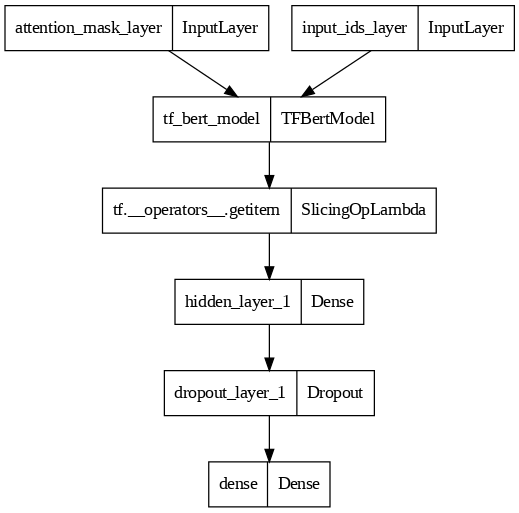

Training Regression with BERT.....
Epoch 1/10
391/391 [==============================] - 174s 420ms/step - loss: 0.9839 - MCRMSE: 0.9839 - val_loss: 0.5564 - val_MCRMSE: 0.5563
Epoch 2/10
391/391 [==============================] - 157s 403ms/step - loss: 0.6986 - MCRMSE: 0.6986 - val_loss: 0.5018 - val_MCRMSE: 0.5018
Epoch 3/10
391/391 [==============================] - 161s 412ms/step - loss: 0.6382 - MCRMSE: 0.6382 - val_loss: 0.4963 - val_MCRMSE: 0.4961
Epoch 4/10
391/391 [==============================] - 161s 411ms/step - loss: 0.6280 - MCRMSE: 0.6280 - val_loss: 0.4743 - val_MCRMSE: 0.4742
Epoch 5/10
391/391 [==============================] - 157s 401ms/step - loss: 0.6152 - MCRMSE: 0.6152 - val_loss: 0.4678 - val_MCRMSE: 0.4678
Epoch 6/10
391/391 [==============================] - 159s 407ms/step - loss: 0.6040 - MCRMSE: 0.6040 - val_loss: 0.4736 - val_MCRMSE: 0.4736
Epoch 7/10
391/391 [==============================] - 157s 401ms/step - loss: 0.5900 - MCRMSE: 0.5900 - val_loss:

,0,1,2,3,4,5,6,7,8,9
loss,0.983941,0.698648,0.638181,0.628006,0.615215,0.603968,0.590027,0.583883,0.578687,0.574314
MCRMSE,0.983941,0.698648,0.638181,0.628006,0.615215,0.603968,0.590027,0.583883,0.578687,0.574314
val_loss,0.556385,0.501832,0.496285,0.474287,0.467800,0.473630,0.462185,0.461875,0.467112,0.454649
val_MCRMSE,0.556338,0.501808,0.496147,0.474212,0.467758,0.473583,0.462167,0.461867,0.467080,0.454655



Plotting loss and MCRMSE...


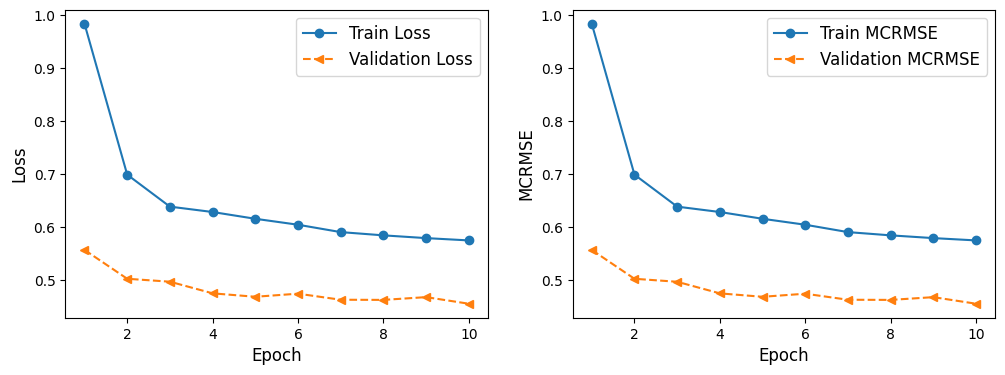

13/13 [==============================] - 16s 1s/step - loss: 0.4826 - MCRMSE: 0.4764

Evaluate Test Metrics:

Test loss: 0.4826

Test MCRMSE score: 0.4764 

13/13 [==============================] - 20s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 6
******************************************************

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
               

None

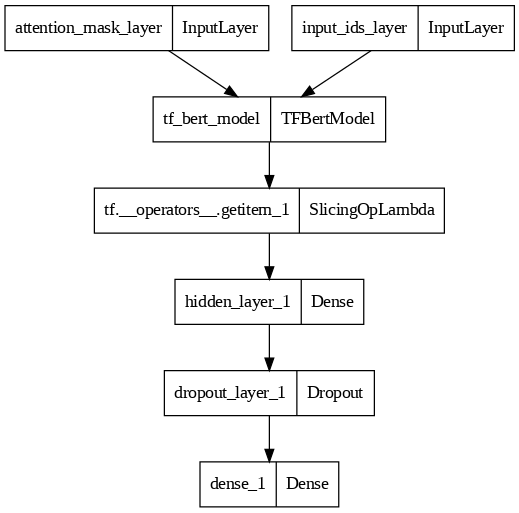

Training Regression with BERT.....
Epoch 1/10
391/391 [==============================] - 171s 423ms/step - loss: 1.1127 - MCRMSE: 1.1127 - val_loss: 0.5690 - val_MCRMSE: 0.5690
Epoch 2/10
391/391 [==============================] - 162s 413ms/step - loss: 0.7412 - MCRMSE: 0.7412 - val_loss: 0.5130 - val_MCRMSE: 0.5129
Epoch 3/10
391/391 [==============================] - 159s 407ms/step - loss: 0.6847 - MCRMSE: 0.6847 - val_loss: 0.5138 - val_MCRMSE: 0.5137
Epoch 4/10
391/391 [==============================] - 161s 411ms/step - loss: 0.6536 - MCRMSE: 0.6536 - val_loss: 0.4743 - val_MCRMSE: 0.4743
Epoch 5/10
391/391 [==============================] - 161s 412ms/step - loss: 0.6352 - MCRMSE: 0.6352 - val_loss: 0.4707 - val_MCRMSE: 0.4707
Epoch 6/10
391/391 [==============================] - 159s 407ms/step - loss: 0.6300 - MCRMSE: 0.6300 - val_loss: 0.4762 - val_MCRMSE: 0.4762
Epoch 7/10
391/391 [==============================] - 161s 411ms/step - loss: 0.6068 - MCRMSE: 0.6068 - val_loss:

,0,1,2,3,4,5,6,7,8,9
loss,1.112710,0.741183,0.684658,0.653625,0.635188,0.630003,0.606769,0.597749,0.592456,0.586959
MCRMSE,1.112710,0.741183,0.684658,0.653625,0.635188,0.630003,0.606769,0.597749,0.592456,0.586959
val_loss,0.568986,0.512967,0.513786,0.474332,0.470683,0.476249,0.468342,0.472794,0.467645,0.457986
val_MCRMSE,0.568962,0.512942,0.513653,0.474299,0.470678,0.476217,0.468341,0.472777,0.467641,0.458024



Plotting loss and MCRMSE...


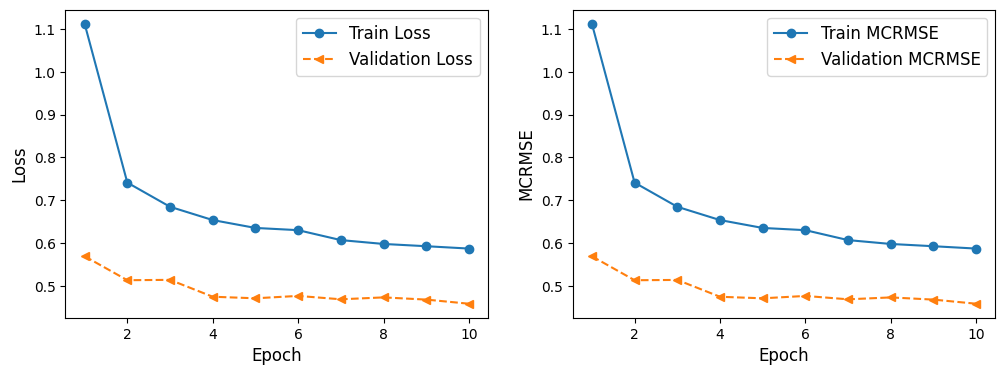

13/13 [==============================] - 16s 1s/step - loss: 0.4845 - MCRMSE: 0.4787

Evaluate Test Metrics:

Test loss: 0.4845

Test MCRMSE score: 0.4787 

13/13 [==============================] - 19s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 12
******************************************************

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
              

None

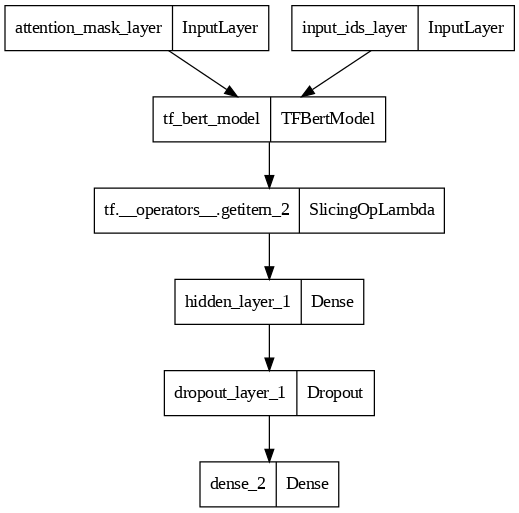

Training Regression with BERT.....
Epoch 1/10


391/391 [==============================] - 305s 722ms/step - loss: 0.7962 - MCRMSE: 0.7962 - val_loss: 0.4718 - val_MCRMSE: 0.4719
Epoch 2/10
391/391 [==============================] - 278s 712ms/step - loss: 0.6794 - MCRMSE: 0.6794 - val_loss: 0.4545 - val_MCRMSE: 0.4545
Epoch 3/10
391/391 [==============================] - 279s 713ms/step - loss: 0.6532 - MCRMSE: 0.6532 - val_loss: 0.4532 - val_MCRMSE: 0.4533
Epoch 4/10
391/391 [==============================] - 272s 696ms/step - loss: 0.6152 - MCRMSE: 0.6152 - val_loss: 0.4584 - val_MCRMSE: 0.4584
Epoch 5/10
391/391 [==============================] - 267s 684ms/step - loss: 0.5925 - MCRMSE: 0.5925 - val_loss: 0.4588 - val_MCRMSE: 0.4588
Epoch 6/10
391/391 [==============================] - 272s 695ms/step - loss: 0.5734 - MCRMSE: 0.5734 - val_loss: 0.4800 - val_MCRMSE: 0.4802
Epoch 7/10
391/391 [==============================] - 267s 683ms/step - loss: 0.5477 - MCRMSE: 0.5477 - val_loss: 0.4985 - val_MCRMSE: 0.4983
Epoch 8/10
391/39

,0,1,2,3,4,5,6,7,8,9
loss,0.796240,0.679424,0.653207,0.615197,0.592527,0.573405,0.547665,0.538007,0.520453,0.505778
MCRMSE,0.796240,0.679424,0.653207,0.615197,0.592527,0.573405,0.547665,0.538007,0.520453,0.505778
val_loss,0.471809,0.454518,0.453220,0.458424,0.458767,0.480012,0.498452,0.450406,0.458841,0.448243
val_MCRMSE,0.471890,0.454511,0.453271,0.458443,0.458800,0.480152,0.498275,0.450420,0.458909,0.448163



Plotting loss and MCRMSE...


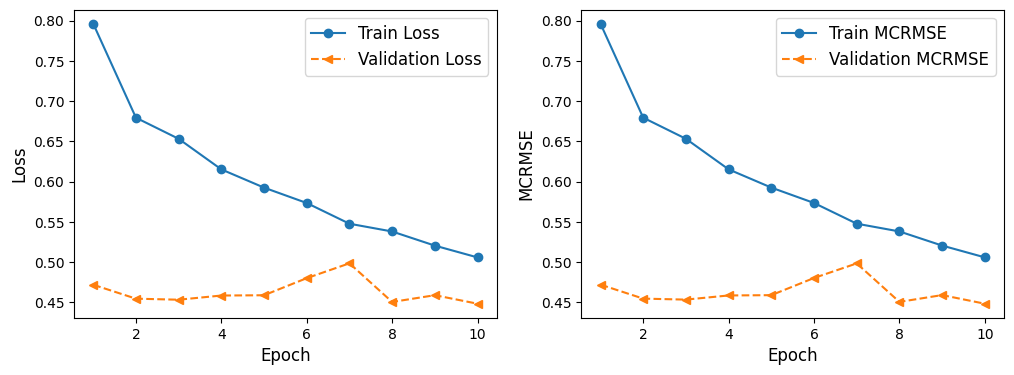

13/13 [==============================] - 16s 1s/step - loss: 0.4701 - MCRMSE: 0.4688

Evaluate Test Metrics:

Test loss: 0.4701

Test MCRMSE score: 0.4688 

13/13 [==============================] - 20s 1s/step


,NLP Model,Num_Trainable_layers,Trainable_Params,Non-Trainable_Params,Epochs,Test_MCRMSE,Test_Loss,Train_MCRMSE,Train_Loss,Val_MCRMSE,Val_Loss,Learning_Rate,Num_Hidden_Layers,Num_hidden_Units,Dropout,Batch_Size
0,bert-base-cased,0,"198,406","108,310,272",10,0.4764,0.4826,0.5743,0.5743,0.4547,0.4546,0.00005,1,256,0.3,8
1,bert-base-cased,6,"198,406","108,310,272",10,0.4787,0.4845,0.5870,0.5870,0.4580,0.4580,0.00005,1,256,0.3,8
2,bert-base-cased,12,"108,508,678",0,10,0.4688,0.4701,0.5058,0.5058,0.4482,0.4482,0.00005,1,256,0.3,8


In [329]:
run_regression_experiment(num_train_layers=np.arange(0,13,6),
                          csv_filename='perf_summary_regression_w_BERT_1.csv')

In [340]:
# !pip install tensorflow-addons
# import tensorflow_addons as tfa
# y_true = np.array([1, 4, 3], dtype=np.float32)
# y_pred = np.array([2, 4, 4], dtype=np.float32)
# metric = tfa.metrics.r_square.RSquare()
# metric.update_state(y_true, y_pred)
# result = metric.result()
# result.numpy()

2) Unfreeze 2, 4, 6, 8, 10, or all 12 layers with randomly chosen values of hyper parameters over 10 epochs


******************************************************
Regression with BERT: Number of Unfrozen Layers = 2
******************************************************

Training Regression with BERT.....
Epoch 1/10


391/391 [==============================] - 228s 538ms/step - loss: 0.8482 - MCRMSE: 0.8482 - val_loss: 0.4708 - val_MCRMSE: 0.4709
Epoch 2/10
391/391 [==============================] - 200s 511ms/step - loss: 0.7071 - MCRMSE: 0.7071 - val_loss: 0.4711 - val_MCRMSE: 0.4710
Epoch 3/10
391/391 [==============================] - 195s 500ms/step - loss: 0.6632 - MCRMSE: 0.6632 - val_loss: 0.4849 - val_MCRMSE: 0.4848
Epoch 4/10
391/391 [==============================] - 202s 516ms/step - loss: 0.6432 - MCRMSE: 0.6432 - val_loss: 0.4362 - val_MCRMSE: 0.4362
Epoch 5/10
391/391 [==============================] - 199s 509ms/step - loss: 0.6319 - MCRMSE: 0.6319 - val_loss: 0.4371 - val_MCRMSE: 0.4371
Epoch 6/10
391/391 [==============================] - 199s 509ms/step - loss: 0.6315 - MCRMSE: 0.6315 - val_loss: 0.4431 - val_MCRMSE: 0.4432
Epoch 7/10
391/391 [==============================] - 199s 509ms/step - loss: 0.6308 - MCRMSE: 0.6308 - val_loss: 0.4496 - val_MCRMSE: 0.4496
Epoch 8/10
391/39

,0,1,2,3,4,5,6,7,8,9
loss,0.848189,0.707123,0.663206,0.643167,0.631945,0.631540,0.630760,0.628583,0.616105,0.620216
MCRMSE,0.848189,0.707123,0.663206,0.643167,0.631945,0.631540,0.630760,0.628583,0.616105,0.620216
val_loss,0.470845,0.471068,0.484944,0.436191,0.437056,0.443138,0.449568,0.437965,0.450281,0.450427
val_MCRMSE,0.470934,0.471011,0.484843,0.436229,0.437144,0.443161,0.449605,0.438090,0.450287,0.450453



Plotting loss and MCRMSE...


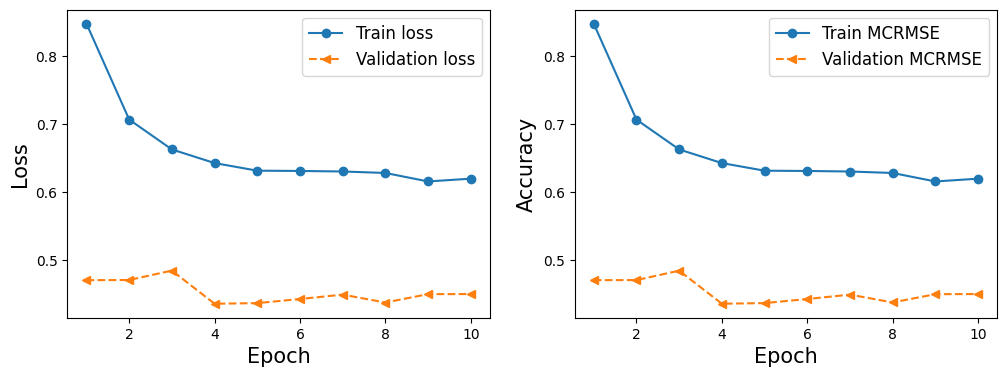

13/13 [==============================] - 16s 1s/step - loss: 0.4656 - MCRMSE: 0.4621

Evaluate Test Metrics:

Test loss: 0.4656

Test MCRMSE score: 0.4621 

13/13 [==============================] - 20s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 4
******************************************************

Training Regression with BERT.....
Epoch 1/10


193/391 [=============>................] - ETA: 1:30 - loss: 0.9458 - MCRMSE: 0.9458

KeyboardInterrupt: ignored

In [86]:
run_regression_experiment(num_train_layers=np.arange(2,13,2),
                          num_hidden_layer=random.choice([1,2]),
                          num_hidden_units=random.choice([64,128,256]),
                          dropout=random.choice([0.1, 0.3, 0.4]),
                          learning_rate=random.choice([0.00005, 0.00001, 0.000001]),
                          batch_size=random.choice([8,16]),
                          csv_filename='perf_summary_regression_w_BERT_2.csv')